In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from math import sqrt
from math import log2
import time
%matplotlib inline

# load different classifieres
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier as RFC


from sklearn.model_selection import train_test_split

# evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# preprocessing 
from sklearn.preprocessing import StandardScaler,PowerTransformer,MinMaxScaler,QuantileTransformer,normalize
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA

# for selection the right path
import os,sys,inspect,pathlib
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import functions

from common import misc
from common.data_parser import *
from common.model_trainer import *
from common.misc import *
from config import *

In [3]:
module_path = pathlib.Path(os.getcwd()).parent
if str(module_path) not in sys.path:
    sys.path.append(str(module_path))
print(sys.path)

from common.dataset_grabber import get_data_path

['/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex1', '/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex1', '/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex1/voting', '', '/home/alexander/ngsuite/ngsolve-install/lib/python3/dist-packages', '/home/alexander/ngsuite/ngsolve-install/bin', '/home/alexander/.local/bin', '/usr/local/sbin', '/usr/local/bin', '/usr/sbin', '/usr/bin', '/sbin', '/bin', '/usr/games', '/usr/local/games', '/snap/bin', '/home/alexander/.vscode/extensions/ms-toolsai.jupyter-2020.11.358541065/pythonFiles', '/home/alexander/.vscode/extensions/ms-toolsai.jupyter-2020.11.358541065/pythonFiles/lib/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/home/alexander/.local/lib/python3.7/site-packages', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/home/alexander/.local/lib/python3.7/site-packages/IPython/extensions', '/home/alexander/.ipython']


In [4]:
datapath_train = get_data_path("Congressional_Voting", "CongressionalVotingID.shuf.lrn.csv")
display(datapath_train)
datapath_test = get_data_path("Congressional_Voting", "CongressionalVotingID.shuf.tes.csv")
display(datapath_test)
datapath_examp = get_data_path("Congressional_Voting", "CongressionalVotingID.shuf.sol.ex.csv")
display(datapath_test)

PosixPath('/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex1/Datasets/Congressional_Voting/CongressionalVotingID.shuf.lrn.csv')

PosixPath('/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex1/Datasets/Congressional_Voting/CongressionalVotingID.shuf.tes.csv')

PosixPath('/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex1/Datasets/Congressional_Voting/CongressionalVotingID.shuf.tes.csv')

In [5]:
df_train = pd.read_csv(datapath_train).drop("ID",axis = 1)
df_test = pd.read_csv(datapath_test).drop("ID",axis = 1)

df_train = df_train.rename(columns={"class": "Class"})
df_train

,Class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,democrat,y,n,y,n,n,n,unknown,y,y,unknown,n,n,n,n,y,unknown
1,democrat,y,y,y,n,n,n,y,y,unknown,n,y,n,n,n,y,unknown
2,democrat,unknown,unknown,unknown,n,n,n,y,y,y,y,n,n,y,n,y,y
3,democrat,y,n,y,n,n,n,y,y,y,y,n,n,n,n,n,y
4,democrat,n,y,y,n,n,n,y,y,y,y,n,n,n,n,y,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,democrat,y,n,y,n,n,n,y,y,y,n,n,n,n,n,y,unknown
214,republican,n,n,n,y,y,y,n,n,n,n,n,y,y,y,y,n
215,democrat,y,y,y,n,n,n,y,y,y,n,n,n,n,n,y,y
216,republican,y,n,y,y,y,y,y,y,n,y,y,y,n,y,y,y


In [6]:
df_train = df_train.replace("n",-1)
df_train = df_train.replace("y",1)
df_train = df_train.replace("unknown",0)


df_test = df_test.replace("n",-1)
df_test = df_test.replace("y",1)
df_test = df_test.replace("unknown",0)

In [9]:
LOGX = True
YLIMS = (0.5, 1)


def plot_params(results, scores="score", fileName=None, params=params, ylims=YLIMS):
    param_keys = list(params)
    first_key = param_keys[0]
    rest = param_keys[1:]

    plt.style.use('seaborn')
    if isinstance(scores, str):
        fix, ax = plt.subplots(figsize=(8,6))
        for vals in tuple(itertools.product(*tuple(x for x in tuple(params.values())[1:]))):
            label = " / ".join([str(x) for x in vals])
            filters = " & ".join([str(x)+' == "'+str(v)+'"' for x, v in zip(rest, vals)])
            results.query(filters).plot(
                x=first_key, y=scores, label=label,
                    ax=ax, marker="o", logx=LOGX);
        plt.legend()
        ax.set_title(scores, fontsize=18)

        plt.ylim(*ylims)
        if fileName:
            plt.savefig(fileName)
        plt.show()
        return plt.gcf() 

SyntaxError: non-default argument follows default argument (<ipython-input-9-bd0a2bf880fc>, line 5)

# Training

In [10]:
X_lrn = df_train.loc[:,"handicapped-infants":]
Y_lrn = df_train.loc[:,"Class":"Class"]

In [11]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_lrn, Y_lrn, test_size=0.4)

In [12]:
MODEL = RFC
MODEL_TYPE = "RFC"
params = {
    "n_estimators": [1, 8, 10, 12, 15, 20, 50, 100,  1000],
    "max_features": ["sqrt", "log2"],
    "criterion": ["gini", "entropy"]
}
SCORES = "accuracy"
OUT_DIR = f"out/{MODEL_TYPE}/"

fname = OUT_DIR + f"{MODEL_TYPE}_{SCORES}.pdf"

In [13]:
LOGX = True
YLIMS = (0.5, 1)


def plot_params(results, scores="score", fileName=None, params=params, ylims=YLIMS):
    param_keys = list(params)
    first_key = param_keys[0]
    rest = param_keys[1:]

    plt.style.use('seaborn')
    if isinstance(scores, str):
        fix, ax = plt.subplots(figsize=(8,6))
        for vals in tuple(itertools.product(*tuple(x for x in tuple(params.values())[1:]))):
            label = " / ".join([str(x) for x in vals])
            filters = " & ".join([str(x)+' == "'+str(v)+'"' for x, v in zip(rest, vals)])
            results.query(filters).plot(
                x=first_key, y=scores, label=label,
                    ax=ax, marker="o", logx=LOGX);
        plt.legend()
        ax.set_title(scores, fontsize=18)

        plt.ylim(*ylims)
        if fileName:
            plt.savefig(fileName)
        plt.show()
        return plt.gcf() 

In [14]:
modeltrainer = ModelTrainer(
    MODEL, 
    params, 
    X_train, Y_train, X_valid, Y_valid, 
    accuracy_score,
    thread_cnt=8
    )
modeltrainer.cm_setup(["democrat", "republican"])    
modeltrainer.train()

modeltrainer.save_result("out/rf_params.csv")
cms = modeltrainer.cms
result_RFC = modeltrainer.result

Finished evaluation
Best parameteters found with: {'n_estimators': 1, 'max_features': 'sqrt', 'criterion': 'entropy'}
score= (0.9545454545454546, 0.9545454545454546)
Total evaluation time = 4.29s


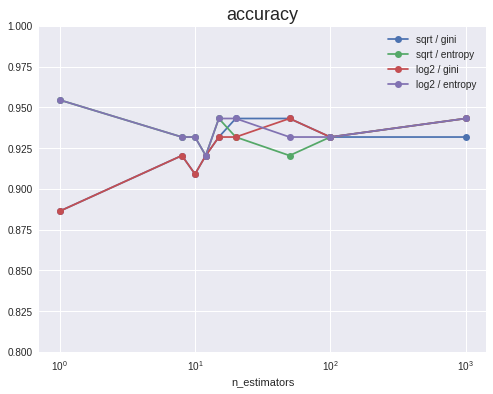

<Figure size 576x396 with 0 Axes>

In [16]:
SCORES = "accuracy"
plot_params(result_RFC, scores=SCORES, fileName=fname,params=params, ylims=(0.8,1));

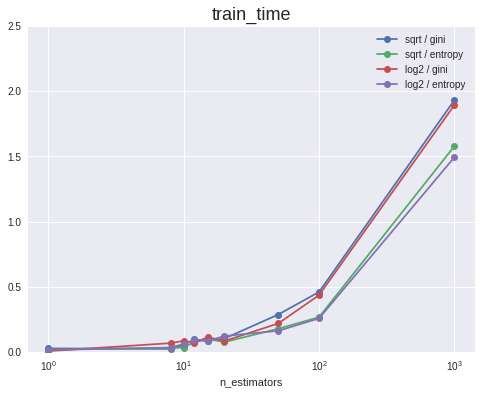

<Figure size 576x396 with 0 Axes>

In [17]:
SCORES = "train_time"
OUT_DIR = f"out/{MODEL_TYPE}/"

fname = OUT_DIR + f"{MODEL_TYPE}_{SCORES}.pdf"
plot_params(result_RFC, scores=SCORES, fileName=fname,params=params, ylims=(0,2.5));

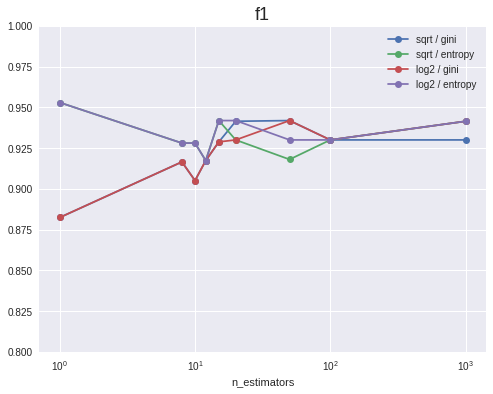

<Figure size 576x396 with 0 Axes>

In [18]:
SCORES = "f1"
OUT_DIR = f"out/{MODEL_TYPE}/"

fname = OUT_DIR + f"{MODEL_TYPE}_{SCORES}.pdf"
plot_params(result_RFC, scores=SCORES, fileName=fname,params=params, ylims=(0.8,1));

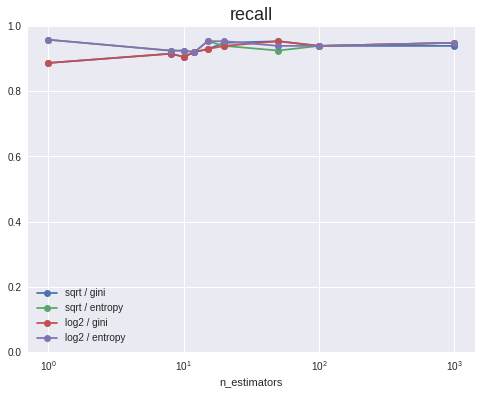

<Figure size 576x396 with 0 Axes>

In [19]:
SCORES = "recall"
OUT_DIR = f"out/{MODEL_TYPE}/"

fname = OUT_DIR + f"{MODEL_TYPE}_{SCORES}.pdf"
plot_params(result_RFC, scores=SCORES, fileName=fname,params=params, ylims=(0,1));

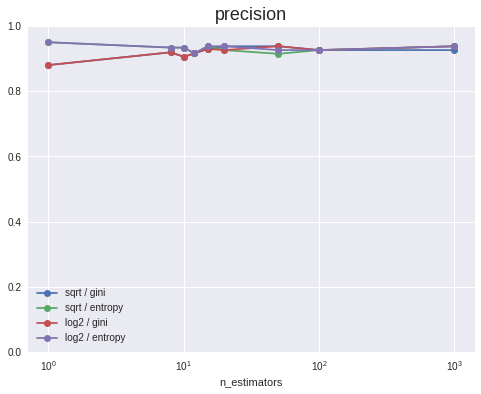

<Figure size 576x396 with 0 Axes>

In [20]:
SCORES = "precision"
OUT_DIR = f"out/{MODEL_TYPE}/"

fname = OUT_DIR + f"{MODEL_TYPE}_{SCORES}.pdf"
plot_params(result_RFC, scores=SCORES, fileName=fname,params=params, ylims=(0,1));

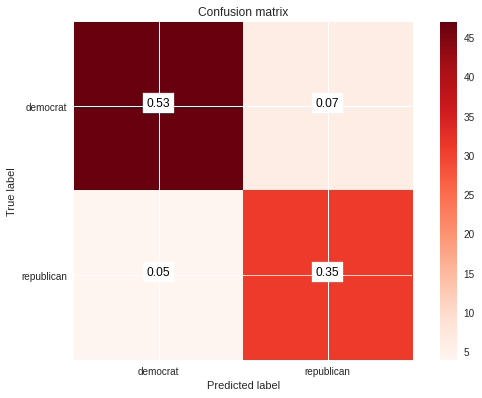

In [21]:
plot_confusion_matrix(cms[0][1], ["democrat", "republican"], normalize=True, title="Confusion matrix", cmap=plt.cm.Reds)
plt.savefig(OUT_DIR + "CM_" + MODEL_TYPE + ".pdf")